In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import os
from PIL import Image, ImageFilter
from PIL import ImageEnhance

In [3]:
input_dir = 'archive'
os.listdir(input_dir)

['CT_COVID', 'CT_NonCOVID']

In [4]:
out_dir = 'preprocessed'

#### Image enhancing

In [5]:
for image_class in os.listdir(input_dir):
    class_output_dir = os.path.join(out_dir, image_class)
    os.makedirs(class_output_dir, exist_ok=True)

    for image in os.listdir(os.path.join(input_dir, image_class)):
        image_path = os.path.join(input_dir, image_class, image)

        try:
            img = Image.open(image_path)


            # Enhance the brightness, contrast, and saturation
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(1.2)  # Increase brightness by 20%

            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(1.5)  # Increase contrast by 50%

            enhancer = ImageEnhance.Color(img)
            img = enhancer.enhance(1.5)  # Increase saturation by 50%

            # 1. Convert to grayscale
            img = img.convert('L')

        


            # 7. Save
            output_path = os.path.join(class_output_dir, image)
            img.save(output_path)


        except Exception as e:
            print(e)

In [5]:
data = tf.keras.preprocessing.image_dataset_from_directory('preprocessed', image_size=(256, 256), label_mode='categorical')

Found 746 files belonging to 2 classes.


In [6]:
data_iter = data.as_numpy_iterator()

In [29]:
batch = data_iter.next()

fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    # show class name
    ax[idx].set_xlabel(data.class_names[batch[1][idx]])

In [9]:
print(batch[0].min(), batch[0].max())

0.0 255.0


In [7]:
# scale the images
data_scaled = data.map(lambda x,y: (x/255.0, y))  # x is the image, y is the label

In [11]:
batch

(array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [1.6230469e+00, 1.6230469e+00, 1.6230469e+00],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [1.2084091e+01, 1.2084091e+01, 1.2084091e+01],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [3.5288589e+01, 3.5288589e+01, 3.5288589e+01],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+

In [8]:
scaled_iter = data_scaled.as_numpy_iterator()
scaled_batch = scaled_iter.next()

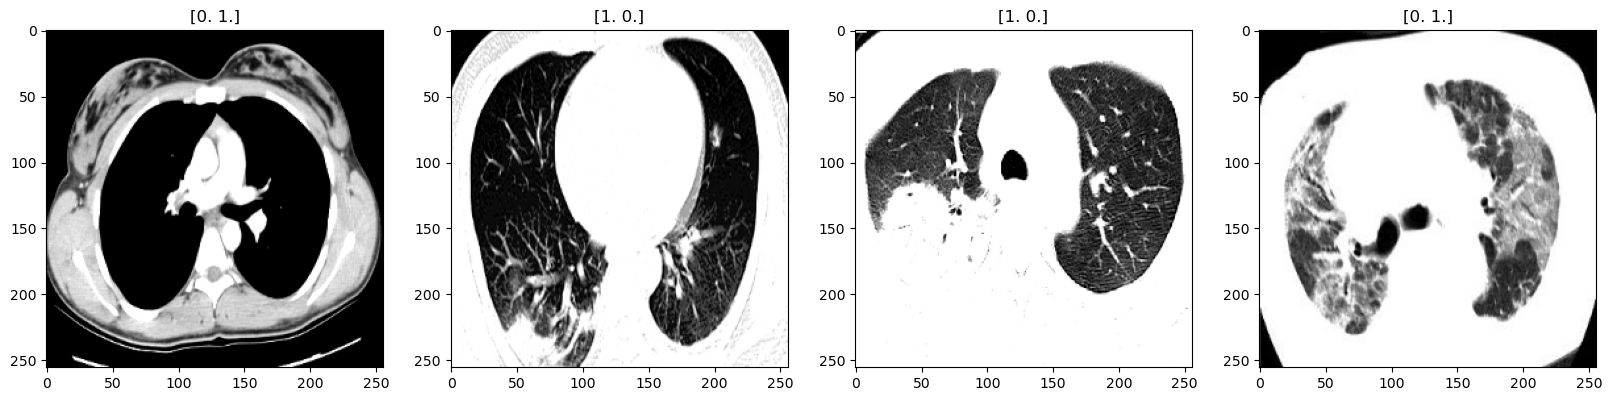

In [13]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(scaled_batch[1][idx])

In [9]:
train_size = int(len(data_scaled)*0.7)
test_size = int(len(data_scaled)*0.2)
val_size = int(len(data_scaled)*0.1)

In [10]:
train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)


In [11]:
# Extract labels
train_labels = []
val_labels = []

for images, labels in train:
    train_labels.extend(labels.numpy())

for images, labels in val:
    val_labels.extend(labels.numpy())

In [12]:
train_labels_encoded = tf.keras.utils.to_categorical(train_labels, num_classes=4)
val_labels_encoded = tf.keras.utils.to_categorical(val_labels, num_classes=4)

### Main simple model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))  # 4 output classes, so change to 4 and use softmax

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [19]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
16/16 [==============================] - 17s 891ms/step - loss: 1.0190 - accuracy: 0.5137 - val_loss: 0.6901 - val_accuracy: 0.4844
Epoch 2/50
16/16 [==============================] - 14s 850ms/step - loss: 0.6633 - accuracy: 0.6016 - val_loss: 0.6023 - val_accuracy: 0.6719
Epoch 3/50
16/16 [==============================] - 12s 748ms/step - loss: 0.5488 - accuracy: 0.7266 - val_loss: 0.4895 - val_accuracy: 0.7188
Epoch 4/50
16/16 [==============================] - 12s 725ms/step - loss: 0.4247 - accuracy: 0.8008 - val_loss: 0.3323 - val_accuracy: 0.8594
Epoch 5/50
16/16 [==============================] - 12s 747ms/step - loss: 0.2928 - accuracy: 0.8711 - val_loss: 0.1941 - val_accuracy: 0.9375
Epoch 6/50
16/16 [==============================] - 12s 729ms/step - loss: 0.1945 - accuracy: 0.9258 - val_loss: 0.1814 - val_accuracy: 0.9531
Epoch 7/50
16/16 [==============================] - 12s 726ms/step - loss: 0.1291 - accuracy: 0.9492 - val_loss: 0.1511 - val_accuracy: 0.9375

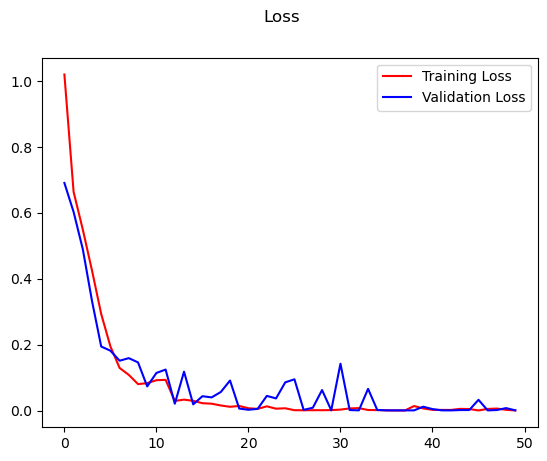

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='Training Loss')
plt.plot(hist.history['val_loss'], color='blue', label='Validation Loss')
fig.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()


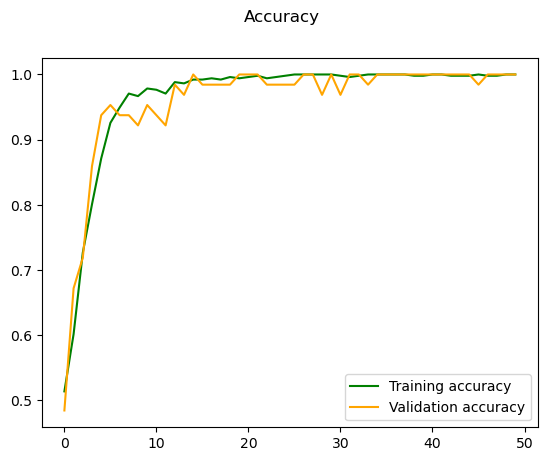

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='Training accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation accuracy')
fig.suptitle('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [22]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

precision = Precision()
recall = Recall()
cat_accuracy = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    images, labels = batch
    preds = model.predict(images)
    precision.update_state(labels, preds)
    recall.update_state(labels, preds)
    cat_accuracy.update_state(labels, preds)


1/1 [==============================] - 0s 157ms/step


In [23]:
print('Precision: ', precision.result().numpy())
print('Recall: ', recall.result().numpy())
print('categorical Accuracy: ', cat_accuracy.result().numpy())

Precision:  1.0
Recall:  1.0
categorical Accuracy:  1.0


### Same model with early stopping and dropouts

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv2D(64, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer with a dropout rate of 0.5
model.add(Dense(2, activation='softmax'))  # 2 output classes, so change to 2 and use softmax

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop training if validation loss doesn't improve for 3 epochs

# Summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [25]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
16/16 [==============================] - 15s 818ms/step - loss: 0.8094 - accuracy: 0.5488 - val_loss: 0.6363 - val_accuracy: 0.5938
Epoch 2/50
16/16 [==============================] - 12s 753ms/step - loss: 0.5897 - accuracy: 0.6680 - val_loss: 0.4814 - val_accuracy: 0.7500
Epoch 3/50
16/16 [==============================] - 12s 724ms/step - loss: 0.4921 - accuracy: 0.7422 - val_loss: 0.4264 - val_accuracy: 0.7656
Epoch 4/50
16/16 [==============================] - 12s 733ms/step - loss: 0.4134 - accuracy: 0.8125 - val_loss: 0.3518 - val_accuracy: 0.8281
Epoch 5/50
16/16 [==============================] - 12s 724ms/step - loss: 0.3286 - accuracy: 0.8438 - val_loss: 0.2021 - val_accuracy: 0.9844
Epoch 6/50
16/16 [==============================] - 12s 758ms/step - loss: 0.2736 - accuracy: 0.8867 - val_loss: 0.2879 - val_accuracy: 0.9062
Epoch 7/50
16/16 [==============================] - 13s 786ms/step - loss: 0.2163 - accuracy: 0.9199 - val_loss: 0.2168 - val_accuracy: 0.9219

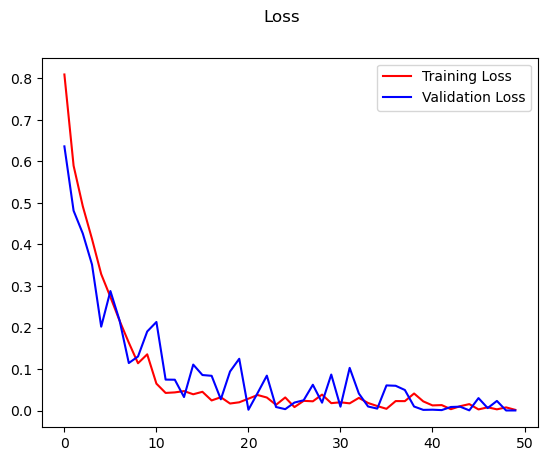

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='Training Loss')
plt.plot(hist.history['val_loss'], color='blue', label='Validation Loss')
fig.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()


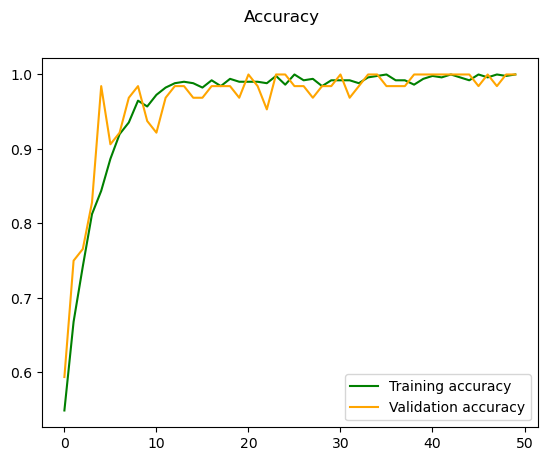

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='Training accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation accuracy')
fig.suptitle('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [28]:
print('Precision: ', precision.result().numpy())
print('Recall: ', recall.result().numpy())
print('categorical Accuracy: ', cat_accuracy.result().numpy())

Precision:  1.0
Recall:  1.0
categorical Accuracy:  1.0


### 5 fold cross validation

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score



def create_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

np.random.seed(0)

n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

accuracies = []


X_train, y_train = train
X_val, y_val = val

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = create_model()

    # Train the model on the current fold
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32)

    # Evaluate the model on the validation fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_val_classes = np.argmax(y_val_fold, axis=1)
    fold_accuracy = accuracy_score(y_val_classes, y_pred_classes)
    accuracies.append(fold_accuracy)


ValueError: too many values to unpack (expected 2)

: 

In [32]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>